In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/epidemy/dengue_labels_train.csv
/kaggle/input/epidemy/dengue_features_train.csv
/kaggle/input/epidemy/dengue_features_test.csv
/kaggle/input/epidemy/submission_format.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from platform import python_version
python_version()

'3.7.12'

In [3]:
# Some stuff from the Feature Engineering Course:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

Some relevant info from google: female mosquito lifetime is 42-56 days, male is 10
That is approximately 7 weeks for female mosquitos. So probably don't need to consider lags beyond that for weather features.

In [4]:
dengue_features_train = pd.read_csv('../input/epidemy/dengue_features_train.csv',parse_dates=True,infer_datetime_format=True)
dengue_features_test = pd.read_csv('../input/epidemy/dengue_features_test.csv',parse_dates=True,infer_datetime_format=True)
dengue_labels_train   = pd.read_csv('../input/epidemy/dengue_labels_train.csv',parse_dates=True,infer_datetime_format=True)


In [5]:
for col in dengue_features_train.columns:
    print(col)

city
year
weekofyear
week_start_date
ndvi_ne
ndvi_nw
ndvi_se
ndvi_sw
precipitation_amt_mm
reanalysis_air_temp_k
reanalysis_avg_temp_k
reanalysis_dew_point_temp_k
reanalysis_max_air_temp_k
reanalysis_min_air_temp_k
reanalysis_precip_amt_kg_per_m2
reanalysis_relative_humidity_percent
reanalysis_sat_precip_amt_mm
reanalysis_specific_humidity_g_per_kg
reanalysis_tdtr_k
station_avg_temp_c
station_diur_temp_rng_c
station_max_temp_c
station_min_temp_c
station_precip_mm


In [6]:
from datetime import date, timedelta
import datetime
import math

debug_date_map=True

# store information on 
date_map_debug_logs=[]

set_of_bad_years=set()

# map from dataframe with year, weekofyear features
# to a time index
# lets go with weeks since day 1 of week 1 of 1990
def date_start_map(x):
    year_one=1990
    week_one=1
    day_of_week=1
    # Trying thursday
    date_one = datetime.datetime.strptime(f"{year_one}-U{week_one}-{day_of_week}","%Y-U%U-%w").date()

    year_current = x['year']
    week_current = x['weekofyear']


    # trouble years are those where this data set incorrectly assigns a week at the 
    # beginning to the end. I've identified these as those starting with Friday, Saturday,
    # or Sunday
    raw_year_current = year_current
    raw_week_current = week_current
    trouble_year=False
    shift = 0
    year_start_date = datetime.datetime.strptime(f"{year_current}-M{1}-{1}","%Y-M%m-%d").date()

    date_two = datetime.datetime.strptime(f"{year_current}-U{week_current}-{day_of_week}","%Y-U%U-%w").date()
    if (year_start_date.weekday() >= 4):
        trouble_year=True
        set_of_bad_years.add(year_current)
        # need better check
        if (week_current >= 52):
            year_current-=1
            # trying to assign to Dec 31
            date_two = datetime.datetime.strptime(f"{year_current}-M{12}-{31}","%Y-M%m-%d").date()
        else:
            shift = 1
            date_two = datetime.datetime.strptime(f"{year_current}-U{week_current}-{day_of_week}","%Y-U%U-%w").date()    
    time_d = date_two - date_one
    weeks = math.ceil(time_d.days / 7.0)
    weeks += shift
    if debug_date_map:
        debug_log=f"{raw_year_current}-{raw_week_current} mapped to week {weeks} using days {time_d.days}"
        date_map_debug_logs.append(debug_log)
    
    return weeks
startmap=date_start_map

dengue_features_train['weeks_since_start']=dengue_features_train.apply(startmap,axis=1)
dengue_features_test['weeks_since_start']=dengue_features_test.apply(startmap,axis=1)
dengue_labels_train['weeks_since_start']=dengue_labels_train.apply(startmap,axis=1)

dengue_features_sj_train=pd.DataFrame(dengue_features_train[dengue_labels_train['city']=='sj'])
dengue_features_sj_test=pd.DataFrame(dengue_features_test[dengue_labels_train['city']=='sj'])
dengue_labels_sj_train=pd.DataFrame(dengue_labels_train[dengue_labels_train['city']=='sj'])

dengue_features_iq_train=pd.DataFrame(dengue_features_train[dengue_labels_train['city']=='iq'])
dengue_features_iq_test=pd.DataFrame(dengue_features_test[dengue_labels_train['city']=='iq'])
dengue_labels_iq_train=pd.DataFrame(dengue_labels_train[dengue_labels_train['city']=='iq'])

list_of_frames=[
    dengue_features_sj_train,
    dengue_features_sj_test,
    dengue_labels_sj_train,
    dengue_features_iq_train,
    dengue_features_iq_test,
    dengue_labels_iq_train
]
for frame in list_of_frames:
    frame.sort_values('weeks_since_start',inplace=True)
    frame.set_index('weeks_since_start',inplace=True)

    
    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


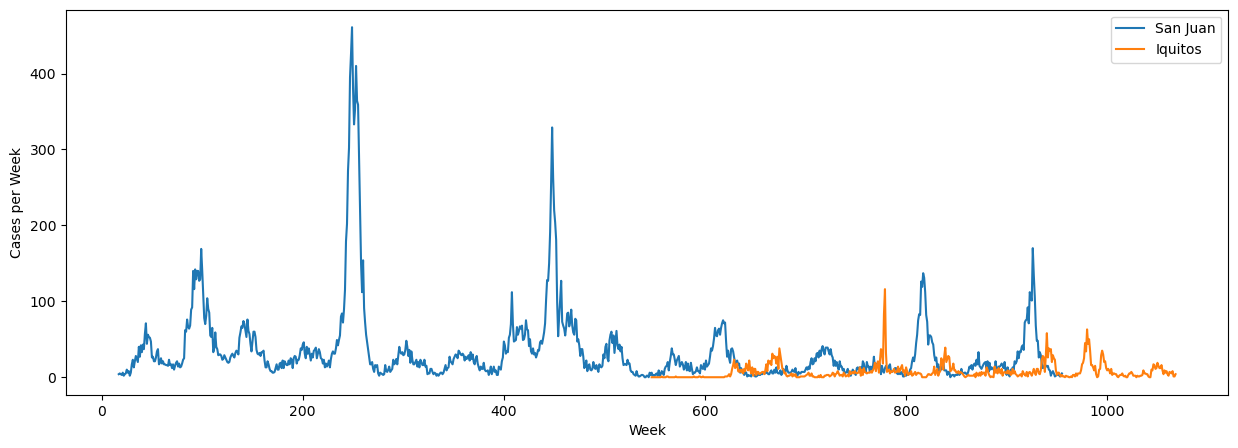

In [7]:
ax=dengue_labels_sj_train.loc[:,['total_cases']].plot(figsize=(15,5))
dengue_labels_iq_train.loc[:,['total_cases']].plot(ax=ax)
ax.legend(['San Juan','Iquitos'])
ax.set(xlabel="Week",ylabel="Cases per Week")
plt.savefig('cases_data.png')

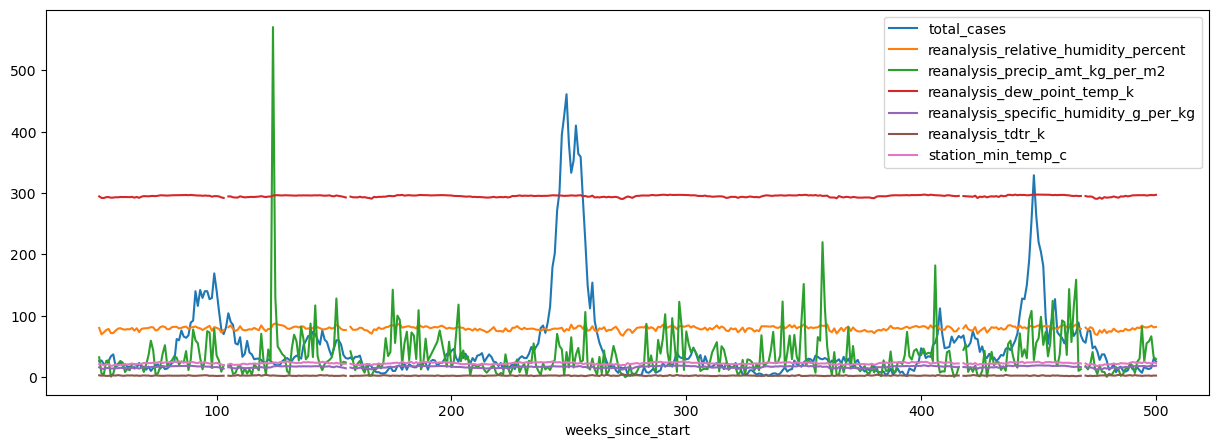

In [8]:
start_week=50
end_week=500

features_to_plot=['reanalysis_relative_humidity_percent',
                  'reanalysis_precip_amt_kg_per_m2',
                  'reanalysis_dew_point_temp_k',
                  'reanalysis_specific_humidity_g_per_kg',
                  'reanalysis_tdtr_k',
                 'station_min_temp_c']
ax=dengue_labels_sj_train.loc[start_week:end_week,['total_cases']].plot(figsize=(15,5))
dengue_features_sj_train.loc[start_week:end_week,features_to_plot].plot(ax=ax)
plt.savefig('test_feature_cmp_sj.png')

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


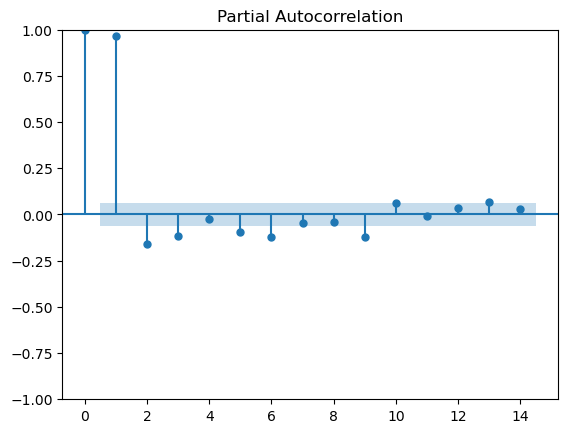

In [9]:
from learntools.time_series.utils import plot_lags, make_lags, make_leads
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(dengue_labels_sj_train['total_cases'], lags=14);
plt.savefig('cases_sj_pacf.png')

# Variables


In [10]:
# Averaging Vegetation Index data
ndvi_features=['ndvi_se','ndvi_sw','ndvi_ne','ndvi_nw']

dengue_features_sj_train_ndvi_mean=dengue_features_sj_train[ndvi_features].mean(axis=1)
dengue_features_sj_train['ndvi_mean']=dengue_features_sj_train_ndvi_mean

In [11]:
precip_variable='reanalysis_sat_precip_amt_mm'
ndvi_variable='ndvi_mean'
rel_hum_variable='reanalysis_relative_humidity_percent'
dew_point_variable='reanalysis_dew_point_temp_k'
mean_temp_variable='reanalysis_avg_temp_k'

variables_of_interest=[precip_variable,ndvi_variable,
                       rel_hum_variable,dew_point_variable,
                       mean_temp_variable]
# for labelling
varnames_of_interest=['precip','ndvi','rel_hum','dew_pt','mean_temp']
vartitles_of_interest=['Precipitation','Vegetation Index','Relative Humidity','Dew Point','Mean Temp']

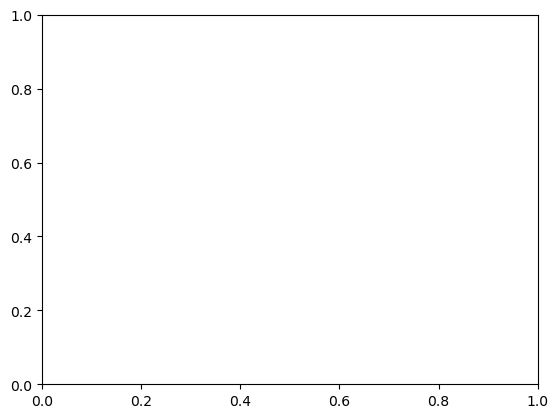

In [12]:
smoothed_features=[]
for i in range(len(variables_of_interest)):
    variable=variables_of_interest[i]
    varname=varnames_of_interest[i]
    vartitle=vartitles_of_interest[i]
    variable_rolling = dengue_features_sj_train[variable].rolling(window=5,center=False).mean()
    smoothed_features.append(variable_rolling)
    ax = dengue_features_sj_train[variable].plot(label=vartitle)
    variable_rolling.plot(ax=ax,label="%s (smoothed)" % (vartitle))
    ax.legend()
    #ax.set_ylabel(vartitle_of_interest[i])
    plt.savefig("variable_%s_smoothed.png" % (varname))
    ax.clear()

# Section: Target and Feature Lags

In [13]:
y_sj=dengue_labels_sj_train['total_cases']

In [14]:
target_lag_number = 12

y_sj_lags=make_lags(dengue_labels_sj_train['total_cases'],lags=target_lag_number)

In [15]:
# can use code from Time Series course

n_lags=24

lags_list=[]
lags_list_no_target=[]
for i in range(len(variables_of_interest)):
    var_lags=make_lags(dengue_features_sj_train[variables_of_interest[i]],
                       lags=n_lags,name=varnames_of_interest[i])
    lags_list.append(var_lags)
    lags_list_no_target.append(var_lags)
    
# add target lags
lags_list.append(y_sj_lags)
    
smoothed_lags_list=[]
smoothed_lags_list_no_target=[]
for i in range(len(variables_of_interest)):
    var_lags=make_lags(smoothed_features[i],
                       lags=n_lags,name="%s_smooth" % (varnames_of_interest[i]))
    smoothed_lags_list.append(var_lags)
    smoothed_lags_list_no_target.append(var_lags)

smoothed_lags_list.append(y_sj_lags)


In [16]:
dengue_features_sj_train_lags=pd.concat(lags_list, axis=1)
dengue_features_no_target_sj_train_lags=pd.concat(lags_list_no_target, axis=1)

dengue_smoothed_features_sj_train_lags=pd.concat(smoothed_lags_list, axis=1)
dengue_smoothed_features_no_target_sj_train_lags=pd.concat(smoothed_lags_list_no_target, axis=1)

In [17]:


X_lags_no_target_for_mi=dengue_features_no_target_sj_train_lags.dropna()
X_lags_for_mi=dengue_features_sj_train_lags.dropna()
#print(X_lags_no_target_for_mi)

(y_lags_no_target_for_mi,X_lags_no_target_for_mi) = y_sj.align(X_lags_no_target_for_mi, join='inner', axis=0)
(y_lags_for_mi,X_lags_for_mi) = y_sj.align(X_lags_for_mi, join='inner', axis=0)
print(X_lags_no_target_for_mi.shape)
print(y_lags_no_target_for_mi.shape)

mi_scores = make_mi_scores(X_lags_no_target_for_mi, y_lags_no_target_for_mi, 'auto')
mi_with_target_scores = make_mi_scores(X_lags_for_mi, y_lags_for_mi, 'auto')

(675, 120)
(675,)


In [18]:
print(mi_scores.head(24))

dew_pt_lag_8        0.258931
dew_pt_lag_6        0.244747
dew_pt_lag_10       0.234146
dew_pt_lag_7        0.229691
dew_pt_lag_11       0.227760
dew_pt_lag_13       0.218671
mean_temp_lag_8     0.217195
mean_temp_lag_10    0.216329
dew_pt_lag_9        0.214798
dew_pt_lag_4        0.199826
mean_temp_lag_9     0.199539
mean_temp_lag_5     0.196884
mean_temp_lag_7     0.196871
dew_pt_lag_12       0.191967
mean_temp_lag_6     0.183684
mean_temp_lag_13    0.176563
dew_pt_lag_5        0.166529
mean_temp_lag_12    0.163275
dew_pt_lag_3        0.159683
mean_temp_lag_11    0.147845
mean_temp_lag_4     0.142231
dew_pt_lag_2        0.139824
rel_hum_lag_8       0.138717
dew_pt_lag_1        0.135086
Name: MI Scores, dtype: float64


In [19]:
print(mi_with_target_scores.head(20))

y_lag_1             1.049853
y_lag_2             0.846082
y_lag_3             0.731886
y_lag_4             0.620714
y_lag_5             0.499057
y_lag_6             0.396698
y_lag_7             0.324619
dew_pt_lag_8        0.256825
y_lag_8             0.246094
dew_pt_lag_10       0.245936
dew_pt_lag_6        0.242962
mean_temp_lag_10    0.225785
dew_pt_lag_7        0.225569
dew_pt_lag_11       0.218923
dew_pt_lag_9        0.218341
mean_temp_lag_8     0.217395
dew_pt_lag_13       0.205745
mean_temp_lag_9     0.205572
mean_temp_lag_7     0.198248
mean_temp_lag_5     0.198149
Name: MI Scores, dtype: float64


Studying Derivatives

In [20]:
y_sj_deriv=dengue_labels_sj_train['total_cases']-y_sj_lags['y_lag_1']

In [21]:
y_sj_deriv_smooth_gaus_mean=y_sj_deriv.rolling(window=7,center=True,win_type='gaussian').mean(std=3)
y_sj_deriv_smooth_const_mean=y_sj_deriv.rolling(window=7,center=True).mean(std=3)


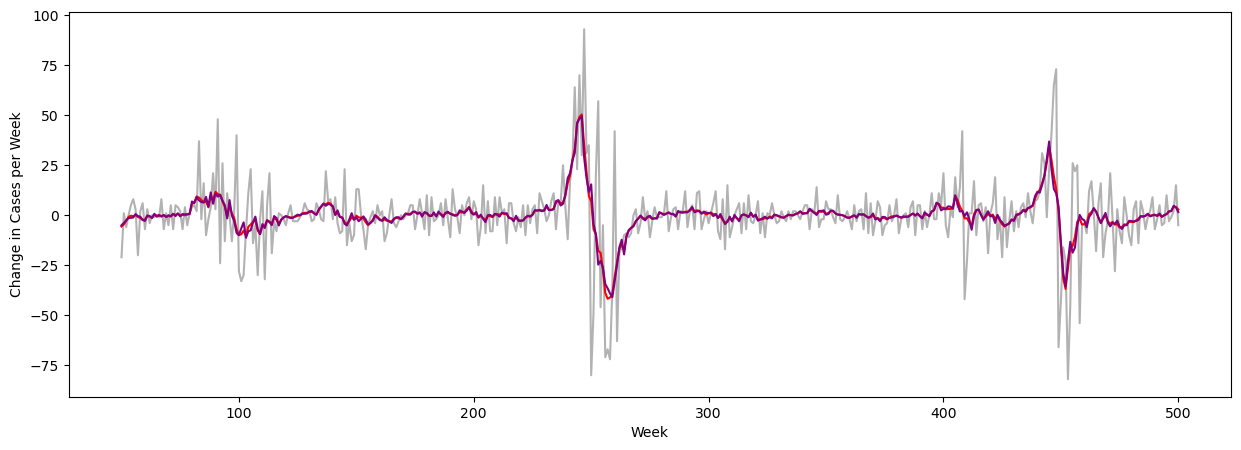

In [22]:
START=50
END=500
ax=y_sj_deriv.loc[START:END].plot(figsize=(15,5),color='black',alpha=0.3)
y_sj_deriv_smooth_gaus_mean.loc[START:END].plot(ax=ax,label='Gaussian Smooth',color='red')
y_sj_deriv_smooth_const_mean.loc[START:END].plot(ax=ax,label='Flat Window',color='purple')
ax.set(xlabel="Week",ylabel="Change in Cases per Week")
plt.savefig("deriv_smoothing.png")

In [23]:
from sklearn.model_selection import train_test_split

def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)

def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=6, desat=None)
    #palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        #preds.index = pd.period_range(start=date, periods=len(preds))
        preds.index = range(date,date+len(preds))
        preds.plot(ax=ax,label=f"Forecast from {date}")
    return ax


In [24]:
target_forecast_steps=20
y_sj_multistep = make_multistep_target(y_sj,steps=target_forecast_steps).dropna()

# Defining Inputs and Models

In [25]:
# each model may require different X,y
# especially based on rows we remove

list_X=[]
list_y=[]

model_list=[]
model_labels=[]
model_titles=[]

X_train_list=[]
X_valid_list=[]
y_train_list=[]
y_valid_list=[]

# Defining Models

In [26]:
from sklearn.linear_model import Ridge,Lasso
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import RegressorChain
from sklearn.metrics import mean_squared_error

In [27]:
n_estimators=30
n_jobs=4

model_1 = RegressorChain(XGBRegressor(n_estimators=n_estimators,n_jobs=n_jobs))
model_list.append(model_1)
model_labels.append("RegChain1_Dew")
model_titles.append("Regressor Chain 1 Dew")

features_for_model=['y_lag_1','y_lag_2','y_lag_3','y_lag_4','y_lag_5',
                    'y_lag_6','y_lag_7','y_lag_8','y_lag_9','y_lag_10',
                    'dew_pt_lag_6','dew_pt_lag_7','dew_pt_lag_8','dew_pt_lag_9',
                    'dew_pt_lag_10','dew_pt_lag_11','dew_pt_lag_12'
                   ]

local_X=dengue_features_sj_train_lags[features_for_model].dropna()
local_y=y_sj_multistep
list_X.append(local_X)
list_y.append(local_y)

model = RegressorChain(XGBRegressor(n_estimators=n_estimators,n_jobs=n_jobs))
model_list.append(model)
model_labels.append("RegChain1_Dew_Temp")
model_titles.append("Regressor Chain 1 Dew Temp")

features_for_model=['y_lag_1','y_lag_2','y_lag_3','y_lag_4','y_lag_5',
                    'y_lag_6','y_lag_7','y_lag_8','y_lag_9','y_lag_10',
                    'dew_pt_lag_6','dew_pt_lag_7','dew_pt_lag_8','dew_pt_lag_9',
                    'dew_pt_lag_10','dew_pt_lag_11','dew_pt_lag_12',
                    'mean_temp_lag_6','mean_temp_lag_7','mean_temp_lag_8',
                    'mean_temp_lag_9','mean_temp_lag_10','mean_temp_lag_11'
                   ]

local_X=dengue_features_sj_train_lags[features_for_model].dropna()
local_y=y_sj_multistep
list_X.append(local_X)
list_y.append(local_y)

# rel_hum_lag_8
model = RegressorChain(XGBRegressor(n_estimators=n_estimators,n_jobs=n_jobs))
model_list.append(model)
model_labels.append("RegChain1_Dew_Temp_Hum")
model_titles.append("Regressor Chain 1 Dew Temp Hum")

features_for_model=['y_lag_1','y_lag_2','y_lag_3','y_lag_4','y_lag_5',
                    'y_lag_6','y_lag_7','y_lag_8','y_lag_9','y_lag_10',
                    'dew_pt_lag_6','dew_pt_lag_7','dew_pt_lag_8','dew_pt_lag_9',
                    'dew_pt_lag_10','dew_pt_lag_11','dew_pt_lag_12',
                    'mean_temp_lag_6','mean_temp_lag_7','mean_temp_lag_8',
                    'mean_temp_lag_9','mean_temp_lag_10','mean_temp_lag_11',
                    'rel_hum_lag_6','rel_hum_lag_7','rel_hum_lag_8',
                    'rel_hum_lag_9','rel_hum_lag_10','rel_hum_lag_11'
                   ]

local_X=dengue_features_sj_train_lags[features_for_model].dropna()
local_y=y_sj_multistep
list_X.append(local_X)
list_y.append(local_y)


# Split the data

In [28]:
test_size=400
for i in range(len(list_X)):
    local_X = list_X[i]
    local_y = list_y[i]
    local_y, local_X = local_y.align(local_X, join='inner', axis=0)
    X_train, X_valid, y_train, y_valid = train_test_split(local_X, local_y, test_size=test_size, shuffle=False)
    
    X_train_list.append(X_train)
    X_valid_list.append(X_valid)
    y_train_list.append(y_train)
    y_valid_list.append(y_valid)

# Run the Fits

In [29]:
for i in range(len(model_list)):
    model=model_list[i]
    
    X_train=X_train_list[i]
    y_train=y_train_list[i]
    
    model.fit(X_train,y_train)

# Produce Predcitions

In [30]:
y_pred_train_list=[]
y_pred_valid_list=[]

for i in range(len(model_list)):
    model=model_list[i]
    X_train=X_train_list[i]
    y_train=y_train_list[i]
    X_valid=X_valid_list[i]
    y_valid=y_valid_list[i]
    
    
    y_pred_train = pd.DataFrame(model.predict(X_train),index=y_train.index,
                              columns=y_train.columns,).clip(0.0)
    y_pred_valid = pd.DataFrame(model.predict(X_valid),index=y_valid.index,
                              columns=y_valid.columns,).clip(0.0)
    y_pred_train_list.append(y_pred_train)
    y_pred_valid_list.append(y_pred_valid)
    
#y_2_pred_train = pd.DataFrame(model_2.predict(X_2_train),index=y_2_train.index,
#                              columns=y_2_train.columns,).clip(0.0)

#y_2_pred_valid = pd.DataFrame(model_2.predict(X_2_valid),index=y_2_valid.index,
#                              columns=y_2_valid.columns,).clip(0.0)


# Run Metrics

In [31]:
rmse_train_list=[]
rmse_valid_list=[]
rsquare_list=[]

for i in range(len(model_list)):
    model=model_list[i]
    X_valid=X_valid_list[i]
    y_train=y_train_list[i]
    y_valid=y_valid_list[i]
    y_pred_train=y_pred_train_list[i]
    y_pred_valid=y_pred_valid_list[i]

    train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
    test_rmse = mean_squared_error(y_valid, y_pred_valid, squared=False)
    
    r_square=model.score(X_valid,y_valid)
    
    rmse_train_list.append(train_rmse)
    rmse_valid_list.append(test_rmse)
    rsquare_list.append(r_square)
    
#print('Model Two:')
#print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))
#print('')

#r_square=model_2.score(X_2_valid,y_2_valid)
#print(f"Model 2 Train R^2: {r_square:.2f}\n")

In [32]:
print(rmse_train_list)
print(rmse_valid_list)
print(rsquare_list)

[18.41479227946684, 18.258080101267844, 18.810136225765017]
[23.066687201861193, 22.461619287619087, 23.42347496675279]
[0.07200102960423259, 0.12559556572182362, 0.049332840023043556]


# Plot Results

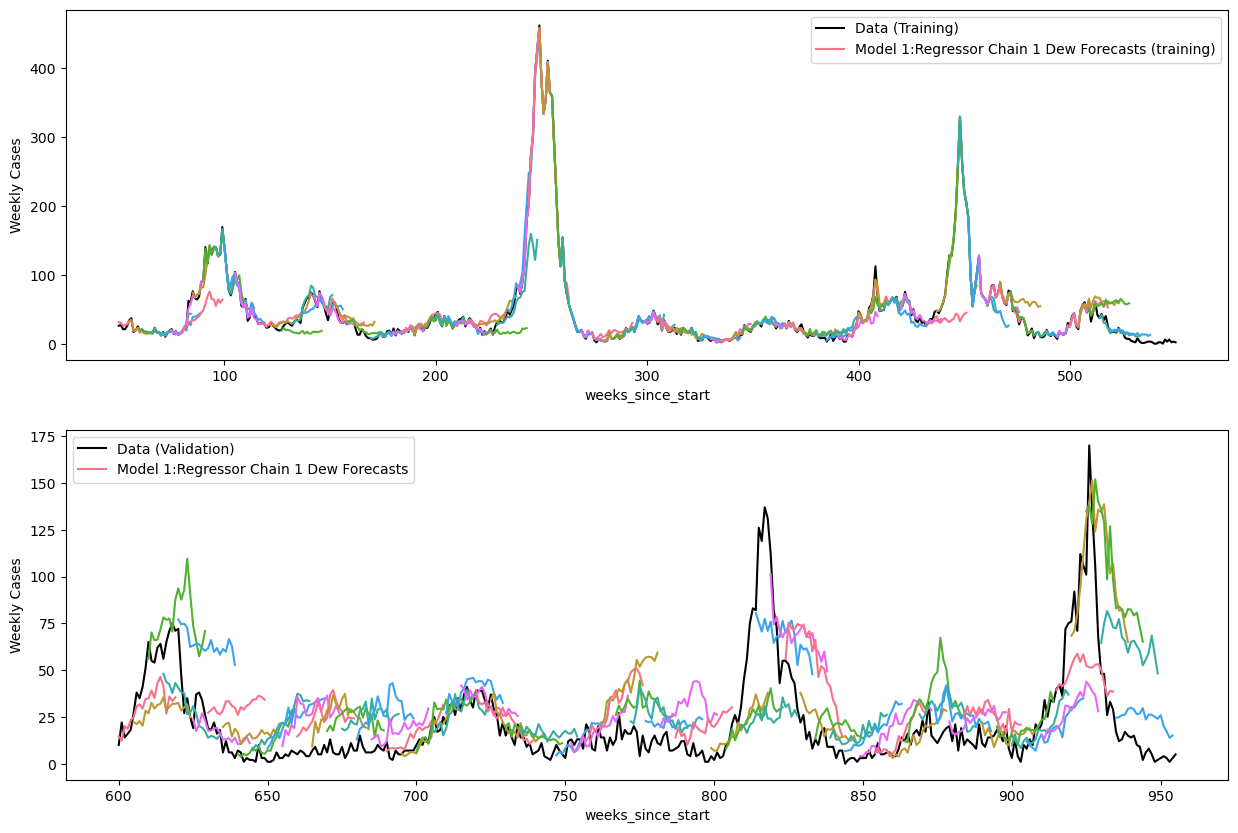

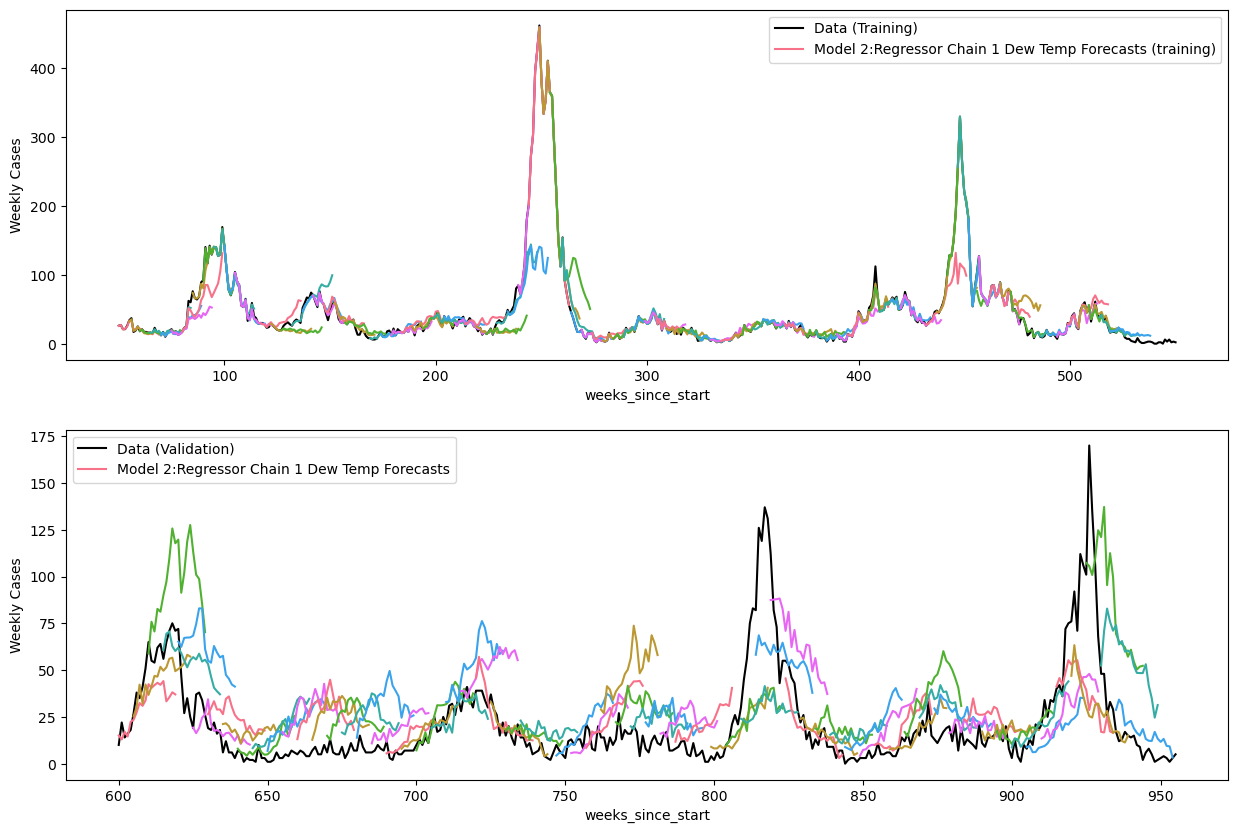

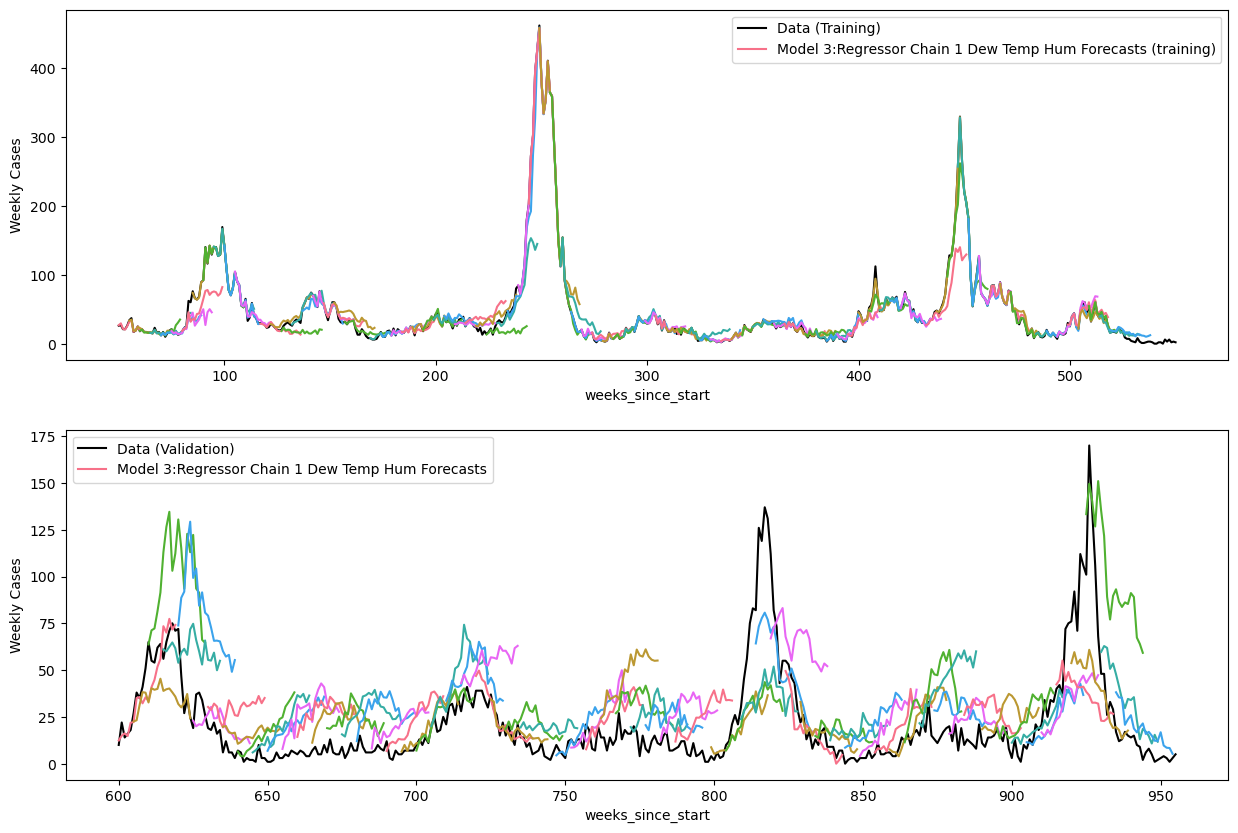

In [33]:

for i in range(len(model_list)):
    y_pred_train = y_pred_train_list[i]
    y_pred_valid = y_pred_valid_list[i]

    model_name  = model_labels[i]
    model_title = model_titles[i]

    EVERY = 5

    START=50
    END=550
    
    fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(15, 10))
    line1 = y_sj.loc[START:END].plot(ax=ax1,label='Data',color='black')

    x=plot_multistep(y_pred_train.loc[START:END],ax=ax1,every=EVERY)
    ax1.set_ylabel('Weekly Cases')
    ax1.legend(['Data (Training)',f'Model {i+1}:{model_title} Forecasts (training)'])

    EVERY = 5

    START=600
    END=1100

    #fig, ax = plt.subplots(1, 1, figsize=(11, 4))
    line1 = y_sj.loc[START:END].plot(ax=ax2,label='Data',color='black')

    x=plot_multistep(y_pred_valid.loc[START:END],ax=ax2,every=EVERY)

    ax2.set_ylabel('Weekly Cases')
    ax2.legend(['Data (Validation)',f'Model {i+1}:{model_title} Forecasts'])

    plt.savefig(f'model_{i+1}_{model_name}.png')